[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/upm-classes/aapi_2023/blob/main/03_convolution_features.ipynb)

## Características de la convolución

Uso de la convolución y kernels para preprocesar una imagen y resaltar características de la imagen o utilizar los resultados como nuevas características de la imagen.

In [98]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
image_path = './images'

Leer la imagen

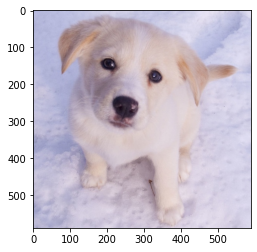

In [99]:
image = cv2.imread(os.path.join(image_path, 'puppy.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # obtain an RGB version

plt.imshow(image)
plt.show()

In [100]:
def convolve(img: np.array, kernel: np.array) -> np.array:
  # Funtion for convolving an image with a kernel, it is not optimized

  # Dimensions of the image are reduced when convolution is applied
  # to avoid this, padding is used before convolution
  h = img.shape[0] - kernel.shape[0] + 1 
  w = img.shape[1] - kernel.shape[1] + 1

  k_h, k_w  = kernel.shape[0], kernel.shape[1]
    
  # 2D array of zeros
  convolved_img = np.zeros(shape=(h, w))
    
  # Iterate over the rows
  for i in range(h):
    # Iterate over the columns
    for j in range(w):
      # img[i, j] = individual pixel value
      # Get the current matrix
      mat = img[i:i+k_h, j:j+k_w]

      # Apply the convolution - element-wise multiplication and summation of the result
      # Store the result to i-th row and j-th column of our convolved_img array
      convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
  return convolved_img

Vamos a realizar algún procesamiento de imágenes.

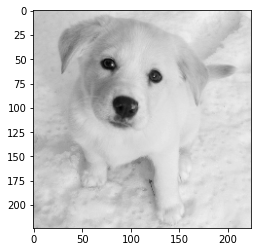

In [101]:
# We convert image into grayscale and normalize to [0,1] range
im = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0

im = cv2.resize(im, (224, 224)) # resize image to 224x224, it works also with RGB

plt.imshow(im, cmap='gray')
plt.show()

#### Difuminando una imagen

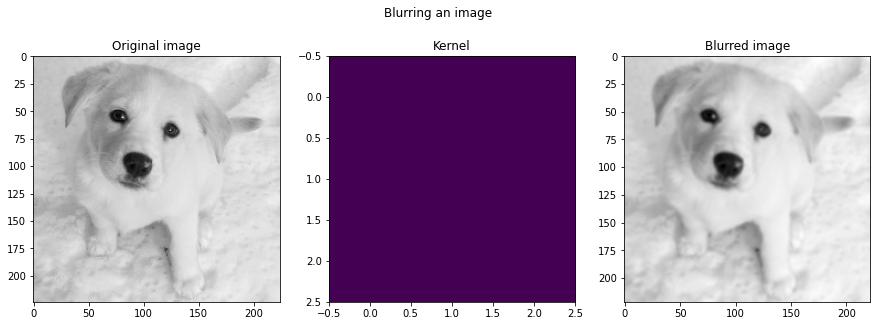

In [102]:
kernel = np.ones((3, 3)) / 9

blurred_img = convolve(im / 255, kernel)
# Normalize image
blurred_img = (blurred_img * 255 / blurred_img.max()).astype(np.uint8)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Blurring an image')
ax1.imshow(im, cmap='gray')
ax1.set_title('Original image')
ax2.imshow(kernel)
ax2.set_title('Kernel')
ax3.imshow(blurred_img, cmap='gray')
ax3.set_title('Blurred image')
plt.show()

#### Kernel para extracción de bordes 

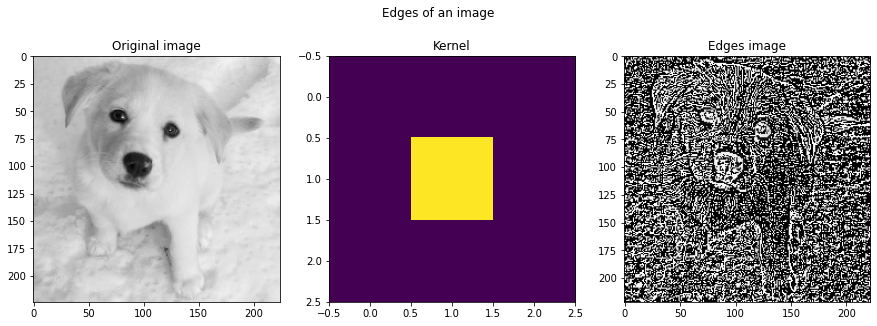

In [110]:
kernel = np.ones((3, 3)) * -1.0
kernel[1, 1] = 8.0

edges_img = convolve(im / 255, kernel)
# Normalize output image for visualization
edges_img = ((edges_img / edges_img.max()) * 255).astype(np.uint8)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Edges of an image')
ax1.imshow(im, cmap='gray')
ax1.set_title('Original image')
ax2.imshow(kernel)
ax2.set_title('Kernel')
ax3.imshow(edges_img, cmap='gray')
ax3.set_title('Edges image')
plt.show()

Otros kernels se pueden visualizar aquí: https://setosa.io/ev/image-kernels/

## Características de las redes neuronales convolucionales (CNN):

Las CNN siguen el mismo principio de convolución con los kernels que se muestran anteriormente. Sin embargo, los kernels son autoaprendidos. La red neuronal aprende los mejores kernels para extraer características.

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import os

try:
  from torchinfo import summary
except:
  ! pip install -U torchinfo
  from torchinfo import summary

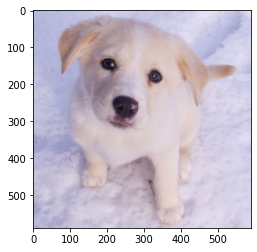

In [4]:
image = imread(os.path.join(image_path, 'puppy.jpg'))

plt.imshow(image)
plt.show()

#### Preprocesado

In [6]:
# resize image
img = resize(image, output_shape=(224, 224), 
             preserve_range=True).astype(np.uint8)

# preprocessing
x = np.expand_dims(img, axis=0) # batch x width x height x channels
x = np.rollaxis(x, 3, 1) # batch x channels x width x height
x = x.astype(np.float32)
x = x - x.mean()
x = x / x.std()

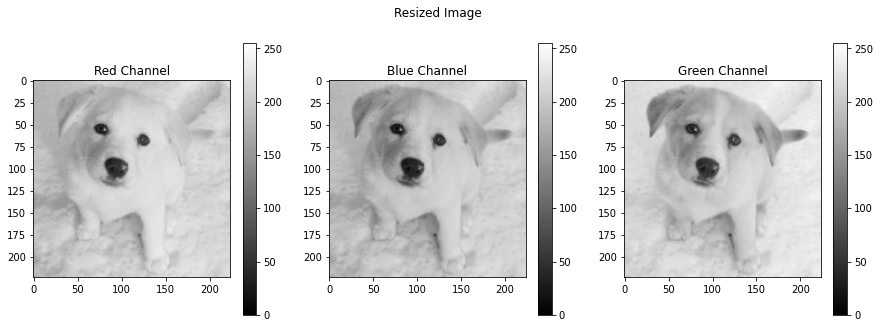

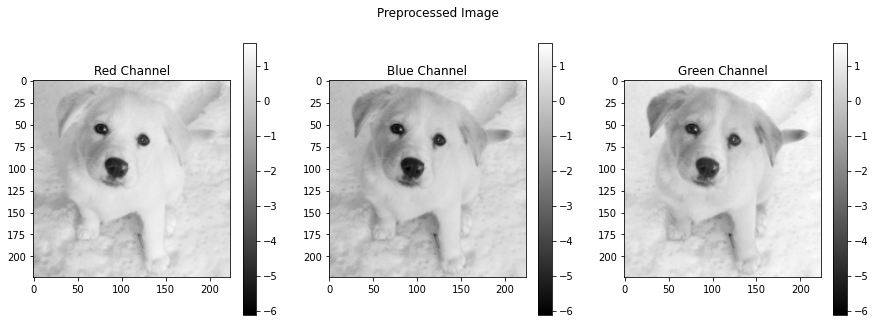

In [7]:
# Plot images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Resized Image')
im1 = ax1.imshow(img[:,:,0], cmap='gray', vmin=0, vmax=255)
plt.colorbar(im1, ax=ax1) # TODO: set the same scale
ax1.set_title('Red Channel')
im2 = ax2.imshow(img[:,:,1], cmap='gray', vmin=0, vmax=255)
plt.colorbar(im2, ax=ax2)
ax2.set_title('Blue Channel')
im3 = ax3.imshow(img[:,:,2], cmap='gray', vmin=0, vmax=255)
plt.colorbar(im3, ax=ax3)
ax3.set_title('Green Channel')
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Preprocessed Image')
im1 = ax1.imshow(np.squeeze(x)[0,:,:], cmap='gray', vmin=x.min(), vmax=x.max())
plt.colorbar(im1, ax=ax1)
ax1.set_title('Red Channel')
im2 = ax2.imshow(np.squeeze(x)[1,:,:], cmap='gray', vmin=x.min(), vmax=x.max())
plt.colorbar(im2, ax=ax2)
ax2.set_title('Blue Channel')
im3 = ax3.imshow(np.squeeze(x)[2,:,:], cmap='gray', vmin=x.min(), vmax=x.max())
plt.colorbar(im3, ax=ax3)
ax3.set_title('Green Channel')
plt.show()

In [8]:
# Download pretrained model
model = models.vgg16(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [9]:
# Summarize structure of the network
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

### Filtros de Convolución

In [92]:
# Function to visualize the filters of a convolution layer
def filter_map(model, image, layer='conv_1'):
  layers = {'conv_1': 1, 'conv_2': 3, 'conv_3': 6, 
          'conv_4': 8, 'conv_5': 11, 'conv_5': 13, 
          'conv_6': 15, 'conv_7': 18, 'conv_8': 20,
          'conv_9': 22, 'conv_10': 25, 'conv_11': 27,
          'conv_12': 29}
  assert layer in layers, 'layer not found'

  filters = model.features[layers[layer] - 1].weight
  num_filters = filters.size(0) if filters.size(0) < 64 else 64
  plt.figure(figsize=(20, 20))
  for i in range(num_filters):
    plt.subplot(num_filters//8, 8, i+1)
    plt.imshow(filters[i, 0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
  plt.show()

Visualicemos los filtros de la primera convolución.

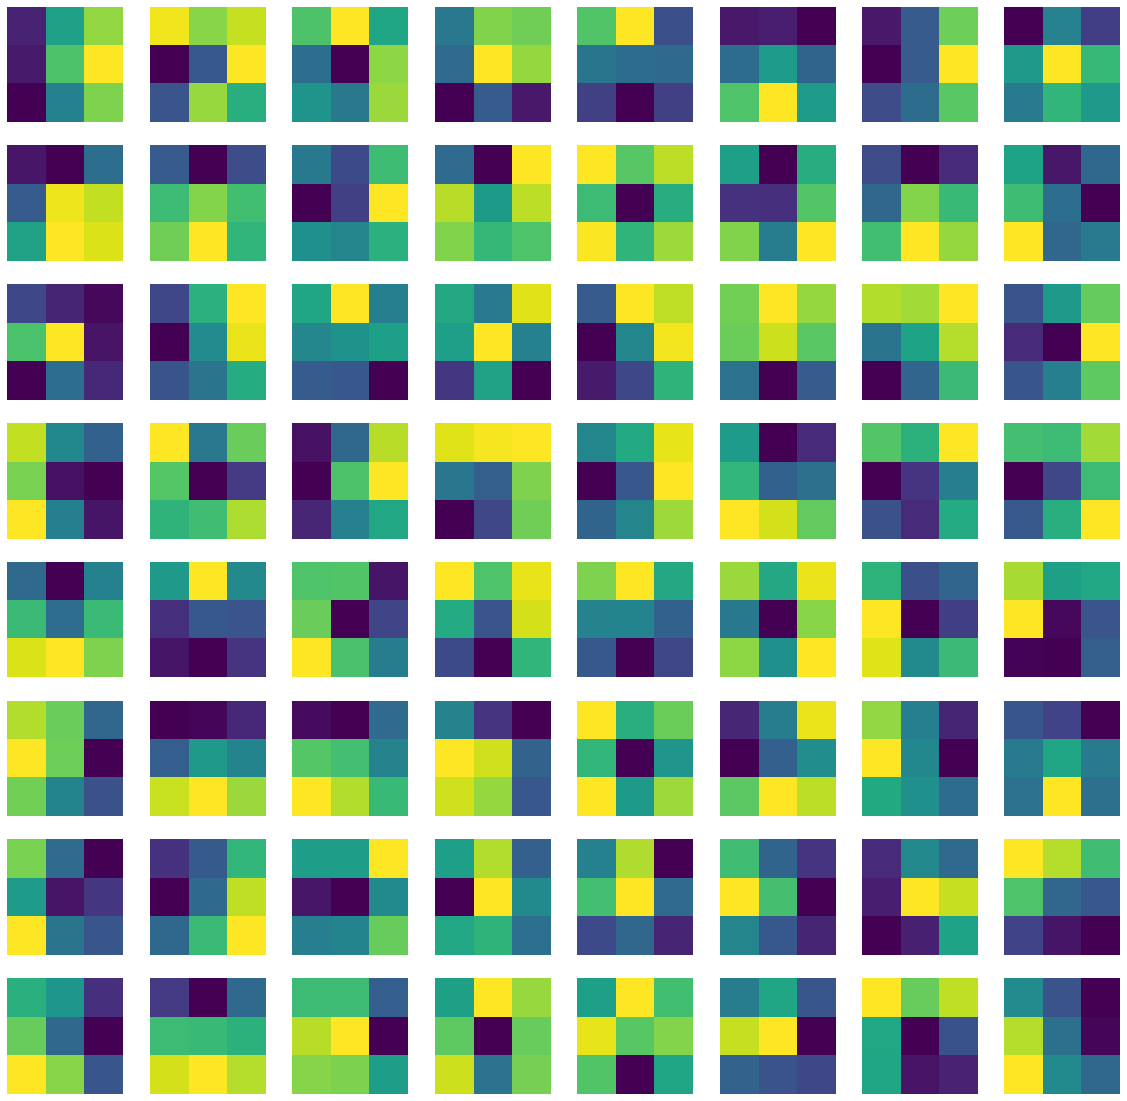

In [93]:
image = torch.from_numpy(x).float()

filter_map(model, image, 'conv_1')

#### Mapas de características de una red preentrenada.

In [94]:
# Function to visualize the feature (activation) maps of a CNN

def feature_map(model, image, layer='conv_1'):
  layers = {'conv_1': 1, 'conv_2': 3, 'conv_3': 6, 
          'conv_4': 8, 'conv_5': 11, 'conv_5': 13, 
          'conv_6': 15, 'conv_7': 18, 'conv_8': 20,
          'conv_9': 22, 'conv_10': 25, 'conv_11': 27,
          'conv_12': 29}
  assert layer in layers, 'layer not found'

  feat_maps = model.features[:layers[layer]](image).detach().squeeze()
  num_feat_maps = feat_maps.size(0) if feat_maps.size(0) < 64 else 64
  plt.figure(figsize=(20, 20))
  for i in range(num_feat_maps):
    plt.subplot(num_feat_maps//8, 8, i+1)
    plt.imshow(feat_maps[i].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
  plt.show()


Visualicemos los mapas de características de la 1ra convolución.

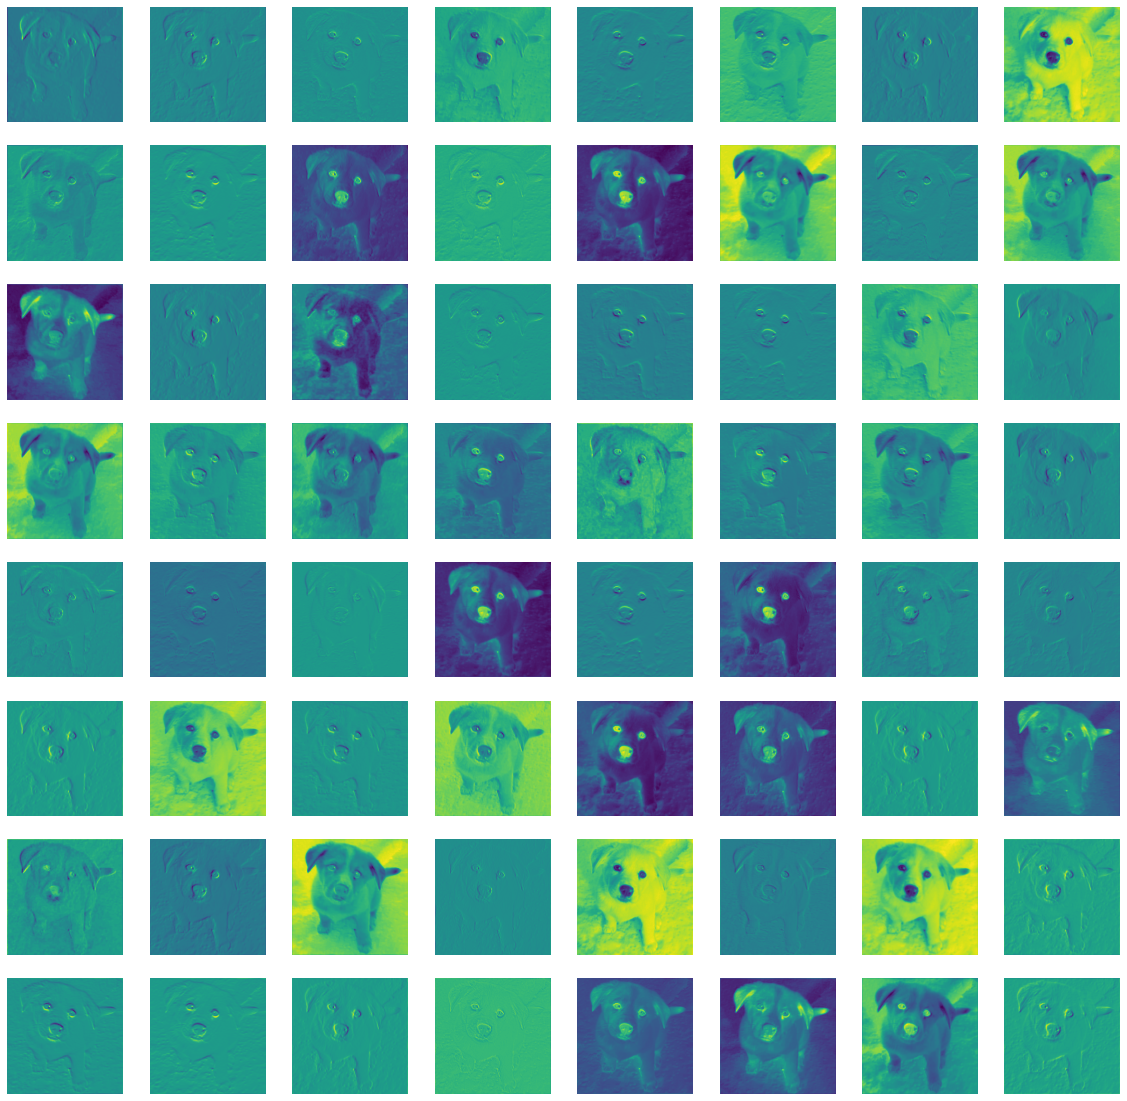

In [95]:
image = torch.from_numpy(x).float()

feature_map(model, image, layer='conv_1')

Visualicemos los mapas de características de la convolución 11.

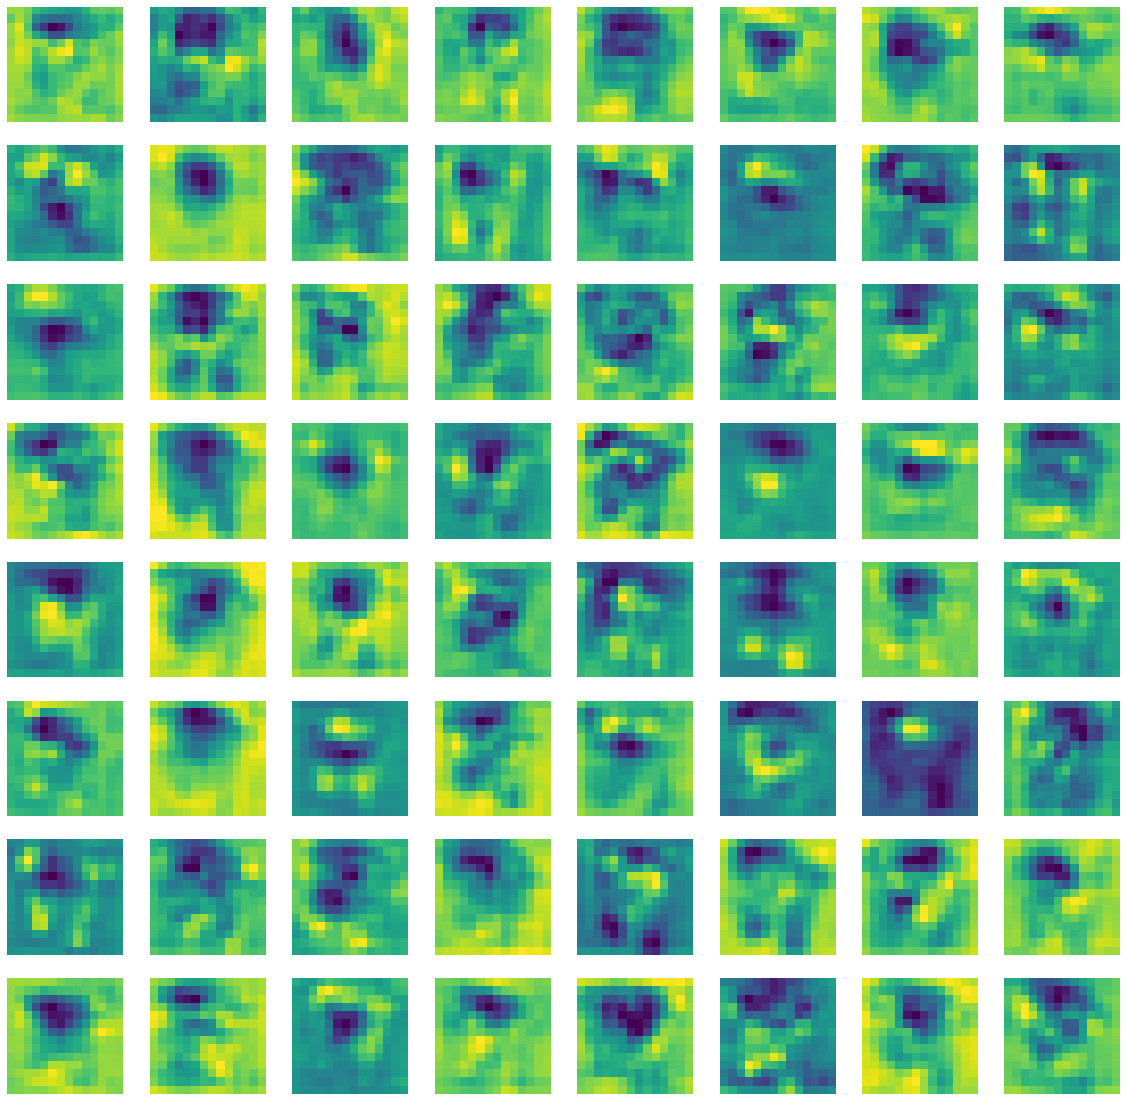

In [96]:
image = torch.from_numpy(x).float()

feature_map(model, image, layer='conv_11')